# PCS956 Project - Diabetes Health Indicators: Exploring Causality for Efficient ML and Explainability

## Overview
This project explores the role of causal understanding in machine learning models using the **CDC Diabetes Health Indicators dataset**. The primary objective is to evaluate how integrating causal knowledge impacts model performance and interpretability. We will:
- Construct a **Directed Acyclic Graph (DAG)** to represent potential causal relationships within the dataset.
- Train baseline machine learning models and compare them to models that leverage causal structures.
- Use explainability tools to analyze model predictions, emphasizing the influence of causal features.

## Dataset Description
### Source and Context
The CDC Diabetes Health Indicators dataset provides healthcare statistics and lifestyle survey information for individuals, including their diabetes diagnosis. This dataset is designed to explore the relationships between various health indicators and the likelihood of diabetes or prediabetes.

### Characteristics
- **Type**: Tabular, Multivariate
- **Subject Area**: Health and Medicine
- **Associated Tasks**: Classification
- **Feature Types**: Categorical, Integer
- **Number of Instances**: 253,680
- **Number of Features**: 21
- **Missing Values**: No

### Data Structure and Variables
The dataset includes 21 variables:
- **Diabetes_binary**: Target variable indicating diabetes status (0 = no diabetes, 1 = prediabetes or diabetes).
- **Features**:
  - **HighBP**: High blood pressure (0 = no, 1 = yes).
  - **HighChol**: High cholesterol (0 = no, 1 = yes).
  - **CholCheck**: Cholesterol check in the past 5 years (0 = no, 1 = yes).
  - **BMI**: Body Mass Index (integer value).
  - **Smoker**: Smoked at least 100 cigarettes in lifetime (0 = no, 1 = yes).
  - **Stroke**: History of stroke (0 = no, 1 = yes).
  - **HeartDiseaseorAttack**: Coronary heart disease or myocardial infarction (0 = no, 1 = yes).
  - **PhysActivity**: Physical activity in the past 30 days, excluding job-related (0 = no, 1 = yes).
  - **Income**: Categorical income levels.
  - **Education**: Categorical education levels.
  - **Additional features**: Demographics (e.g., age, sex), mental health indicators, etc.

### Project Steps
1. **Data Import and Preprocessing**:
   - Load the dataset and prepare it for analysis.
   - Check data consistency and handle any preprocessing requirements.

2. **DAG Construction and Validation**:
   - Build an initial DAG using domain expertise and statistical insights.
   - Validate the DAG through iterative pruning and edge addition to ensure acyclic structure.

3. **Model Development**:
   - Develop baseline models (e.g., Logistic Regression, Random Forest).
   - Train a causally-informed model using selected variables from the DAG.

4. **Explainability Analysis**:
   - Integrate SHAP or LIME to assess feature importance and model predictions.
   - Focus on how causal features contribute to explainability.

5. **Conclusion**:
   - Summarize the impact of causal integration on model performance and interpretability.
   - Discuss future directions for refining causal approaches in ML.

## Additional Information
The CDC created this dataset to understand the relationship between lifestyle factors and diabetes prevalence in the U.S. It includes sensitive data like gender, income, and education level, and it has been preprocessed to include no missing values. Further details can be found at the CDC's [dataset page](https://www.cdc.gov/brfss/annual_data/annual_2014.html).

# **Data Import and Preprocessing**:


In [1]:
import pandas as pd
from scipy.stats import spearmanr
from pgmpy.models import BayesianNetwork
import networkx as nx
import matplotlib.pyplot as plt
from preprocessing.dag_validation import run_dag_validation_tests

# Load the data as per the instructions provided
from ucimlrepo import fetch_ucirepo
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Add the target variable 'Diabetes_binary' to the dataset for correlation analysis
X = X.assign(Diabetes_binary=y)

# Calculate the Spearman correlation matrix for the dataset
correlation_matrix = X.corr(method='spearman')

/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Checking for Duplicates

When training machine learning models, particularly algorithms like logistic regression and generalized linear models (GLMs), it is crucial to ensure that the dataset does not contain duplicate entries. While logistic regression and GLMs do not strictly require observations to be **identically distributed**, they do assume **independence of observations**. This means that each observation should not influence or provide information about another. Duplicate observations can lead to biased model training, overfitting, or misinterpretations of feature importance, ultimately impacting the validity of the model's conclusions.

**Investigation of Duplicates and Temporal Dependencies:**  
Our diabetes dataset, containing health indicators, may have temporal elements or repeated measurements. It is essential to investigate whether duplicates represent legitimate repeated observations, such as those from longitudinal studies, or are errors. If these duplicates are associated with a time series structure, it indicates potential temporal dependencies. These dependencies must be understood and properly handled to avoid violating the independence assumption critical for reliable model performance and interpretation.

By searching for duplicates and examining their nature, we can identify potential issues related to the independence assumption and determine if our dataset has temporal patterns that need special handling. This ensures that the data meets the requirements for valid and unbiased model training.

In [2]:
# Extract the IDs
ids = cdc_diabetes_health_indicators.data.ids

# Check for duplicate IDs
duplicate_ids = ids.duplicated(keep=False)  # Find duplicated IDs, keeping all instances of duplicates
duplicates_df = ids[duplicate_ids]

# Display the number of duplicate entries and a sample of the duplicated IDs
print(f"Number of duplicate entries found: {duplicates_df.shape[0]}")
print("Sample of duplicate entries:")
print(duplicates_df.head())

# Display unique counts for the duplicated IDs
unique_counts = duplicates_df.value_counts()
print("ID counts in duplicate entries:")
print(unique_counts)

Number of duplicate entries found: 0
Sample of duplicate entries:
Empty DataFrame
Columns: [ID]
Index: []
ID counts in duplicate entries:
Series([], Name: count, dtype: int64)


# **DAG Construction and Validation**

In the process of constructing and validating a Directed Acyclic Graph (DAG) for our project, we rely on a foundational approach that combines theoretical understanding with practical algorithmic applications. This approach allows us to construct a DAG that accurately represents the relationships between the variables in our dataset. The validation of edges in the DAG plays a critical role in ensuring the graph’s accuracy and faithfulness to the underlying data relationships. Here, we delve into how we validate these edges using conditional independence tests and why selecting the correct statistical test for each data type is essential.

### The Role of Conditional Variables in Edge Validation

A crucial part of DAG construction is identifying the conditional dependencies between variables. In practical terms, this means determining if the relationship between two variables $X$ and $Y$ holds when conditioned on a set of other variables $Z$. Conditional independence tests are performed iteratively to assess whether an edge between two nodes should exist or be removed based on their conditional dependencies.

The PC algorithm, which we use to build the DAG, begins with a fully connected graph and iteratively prunes edges by testing conditional independence:

1. **Initialize the Graph**: The graph starts with all possible edges between nodes.
2. **Conditional Independence Testing**: For each pair of connected nodes $(X, Y)$, we test if they are conditionally independent given a conditioning set $Z$ of size $d$. If $X$ and $Y$ are found to be conditionally independent given $Z$, the edge between them is removed.
3. **Iterative Pruning**: The process repeats, incrementing $d$, until no further edges can be removed without violating the conditions of the algorithm.

### The Nature of Our Data and Test Selection

Our dataset comprises both **binary** and **numerical** features:

- **Binary Variables**: Variables such as `HighBP`, `HighChol`, `CholCheck`, `Smoker`, `Stroke`, `HeartDiseaseorAttack`, and `PhysActivity` are binary, indicating the presence (1) or absence (0) of a condition or behavior.
- **Numerical Variables**: Features like `BMI` are represented as integer values that provide quantitative information about an individual's body characteristics.

Given the mixed nature of the data, it is essential to choose the appropriate statistical test for each pair of variables when testing conditional independence:

- **Chi-Squared Test**: Used for pairs of binary or categorical variables. This non-parametric test evaluates whether two variables are independent by comparing the observed frequencies in the contingency table with the expected frequencies if the variables were truly independent.
- **Pearson Correlation Test**: Applied when at least one of the variables is numerical. This test assesses the linear relationship between two continuous variables. When used in conditional independence testing, the correlation test considers whether the association between variables holds when conditioned on another variable.

### Selective Test Application in the PC Algorithm

Our algorithm dynamically selects between the Chi-squared test and Pearson correlation based on the types of variables being tested:

- **Binary vs. Binary**: If both $X$ and $Y$ are binary, the Chi-squared test is applied. This test effectively determines if the presence or absence of one variable is independent of the other within the context of the conditioning set $Z$.
- **Numerical or Mixed Types**: If at least one variable is numerical, the Pearson correlation test is used. This approach calculates the linear relationship between $X$ and $Y$ and verifies its significance, even when conditioned on $Z$.

This dynamic approach to choosing the statistical test ensures that the algorithm maintains accuracy and efficiency in identifying valid edges for the DAG.

### Detailed Example of Edge Validation

Consider the pair $(X, Y)$ with a conditioning set $Z$:

1. **Initial Check**: Start with a set $Z$ of size $d = 0$ (i.e., no conditioning set).
2. **Statistical Test**:
   - If $X$ and $Y$ are binary (e.g., `HighBP` and `HighChol`), apply the **Chi-squared test**.
   - If $X$ is binary and $Y$ is numerical (e.g., `HighBP` and `BMI`), apply the **Pearson correlation test**.
3. **Conditional Independence Result**:
   - If the test result indicates that $X$ and $Y$ are independent given $Z$, the edge is removed.
   - If they are not independent, retain the edge and continue with larger conditioning sets.

### Significance Level and Edge Retention

The significance level $\alpha$ plays a crucial role in these tests. It determines the threshold for rejecting the null hypothesis of independence:

- **Chi-Squared Test**: If the p-value is greater than $\alpha$, independence is assumed, and the edge is removed.
- **Pearson Correlation**: Similarly, if the p-value of the correlation test is above $\alpha$, the variables are deemed independent given $Z$.

This rigorous approach ensures that only statistically significant edges remain in the final DAG, aligning with the causal structure inferred from the data.

### Conclusion

The construction and validation of a DAG using conditional independence tests involve a detailed iterative process where each edge is evaluated based on its dependency, conditioned on subsets of the graph. By leveraging the properties of our dataset—binary and numerical variables—we dynamically apply the most appropriate test, either Chi-squared or correlation, ensuring that our final model accurately represents the underlying causal structure.


In [13]:
from pgmpy.base import DAG
from pgmpy.estimators import PC
from pgmpy.estimators.CITests import chi_square, pearsonr

X_sample = X

# Step 2: Initialize the PC estimator with the data
pc_estimator = PC(data=X_sample)

# Step 3: Define the dynamic CI test function
def dynamic_ci_test(data):
    def inner_ci_test(X, Y, Z, **kwargs):
        is_X_categorical = data[X].nunique() <= 2
        is_Y_categorical = data[Y].nunique() <= 2

        if is_X_categorical and is_Y_categorical:
            return chi_square(X=X, Y=Y, Z=Z, **kwargs)
        else:
            return pearsonr(X=X, Y=Y, Z=Z, **kwargs)

    return inner_ci_test

# Step 4: Refine the initial DAG using the PC algorithm and the dynamic CI test
dag = pc_estimator.estimate(
    variant='parallel',
    ci_test=dynamic_ci_test(X_sample),
    max_cond_vars=2,
    significance_level=0.15,
    show_progress=True
)

Working for n conditional variables: 2: 100%|██████████| 2/2 [04:50<00:00, 145.24s/it]


### Visualise

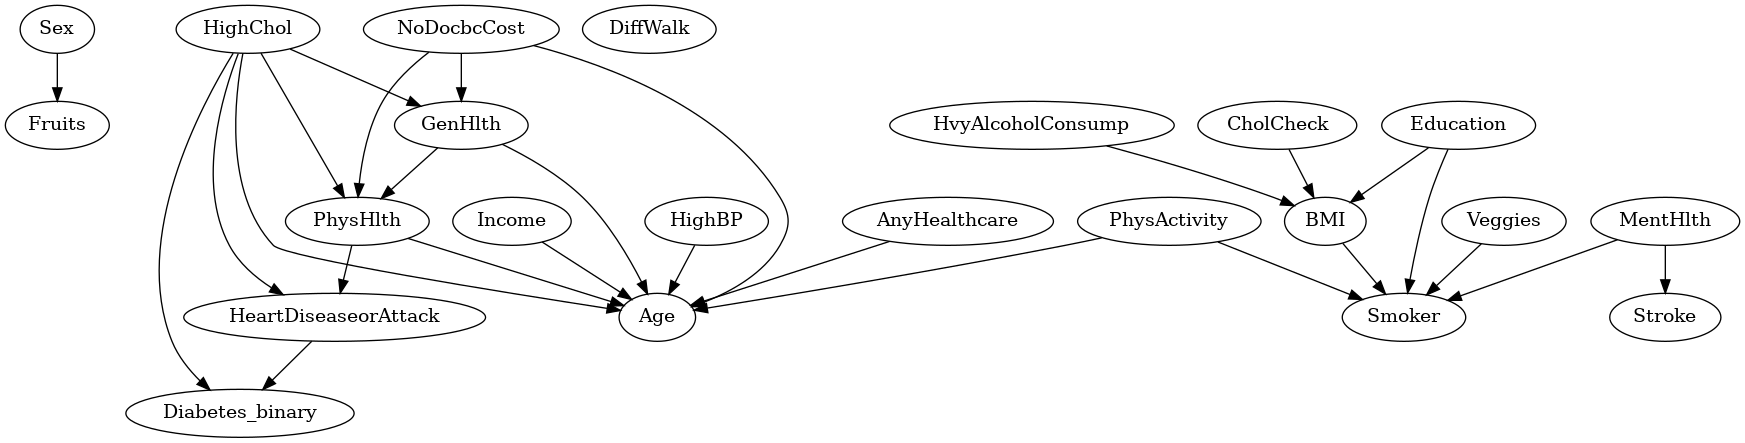

In [12]:
# Convert model to a pygraphviz object
model_graphviz = dag.to_graphviz()

# Plot the model
model_graphviz.draw("learned_dag.png", prog="dot")  # Save as PNG
model_graphviz.draw("learned_dag.pdf", prog="dot")  # Save as PDF
model_graphviz.draw("learned_dag.svg", prog="dot")  # Save as SVG

# Optionally, view the plot in Jupyter Notebook (requires Image module from IPython)
from IPython.display import Image
Image(filename="learned_dag.png")

# **Model Development**